In [1]:
from util.activation_visualization import dataset_average, effective_receptive_field, backprop_maximization, activation_triggered_average, rescaleZeroOne, get_input_output_shape, multiplot
from receptive_fields.util.experiment_setup import open_experiment
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from receptive_fields.models.simple import SimpleCNN
from receptive_fields.util.modules import MisalignedStridedConv2d

import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchinfo import summary
import numpy as np
from util.image import fit_gabor_filter
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from util.image import weighted_hough_line
import os.path as osp
import yaml
import argparse

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [15]:
model_path = "../models/areadne_submission/pool_large_ks6"
model, train_data= open_experiment(model_path)
train_loader = DataLoader(train_data, batch_size=10, shuffle=False)

in_channels = model.in_channels
img_size = model.img_size

# model_conf = model.config['config']
# model_conf['padding']=100
# model=SimpleCNN(**model_conf)

model = model.get_sequential()[:-6].to(device)
summary(model, (1,in_channels,*img_size[::-1]))

Files already downloaded and verified


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 128]                  --
├─Conv2d: 1-1                            [1, 32, 115, 155]         3,488
├─ELU: 1-2                               [1, 32, 115, 155]         --
├─AvgPool2d: 1-3                         [1, 32, 57, 77]           --
├─Conv2d: 1-4                            [1, 32, 52, 72]           36,896
├─ELU: 1-5                               [1, 32, 52, 72]           --
├─AvgPool2d: 1-6                         [1, 32, 26, 36]           --
├─Conv2d: 1-7                            [1, 32, 21, 31]           36,896
├─ELU: 1-8                               [1, 32, 21, 31]           --
├─AvgPool2d: 1-9                         [1, 32, 10, 15]           --
├─Conv2d: 1-10                           [1, 32, 5, 10]            36,896
├─ELU: 1-11                              [1, 32, 5, 10]            --
├─AvgPool2d: 1-12                        [1, 32, 2, 5]             --


In [16]:
model.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(6, 6), stride=(1, 1))
  (1): ELU(alpha=1.0, inplace=True)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(32, 32, kernel_size=(6, 6), stride=(1, 1))
  (4): ELU(alpha=1.0, inplace=True)
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(32, 32, kernel_size=(6, 6), stride=(1, 1))
  (7): ELU(alpha=1.0, inplace=True)
  (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (9): Conv2d(32, 32, kernel_size=(6, 6), stride=(1, 1))
  (10): ELU(alpha=1.0, inplace=True)
  (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=320, out_features=128, bias=True)
  (14): ELU(alpha=1.0, inplace=True)
)

## Intermediate Representation

torch.Size([10, 32, 52, 72])


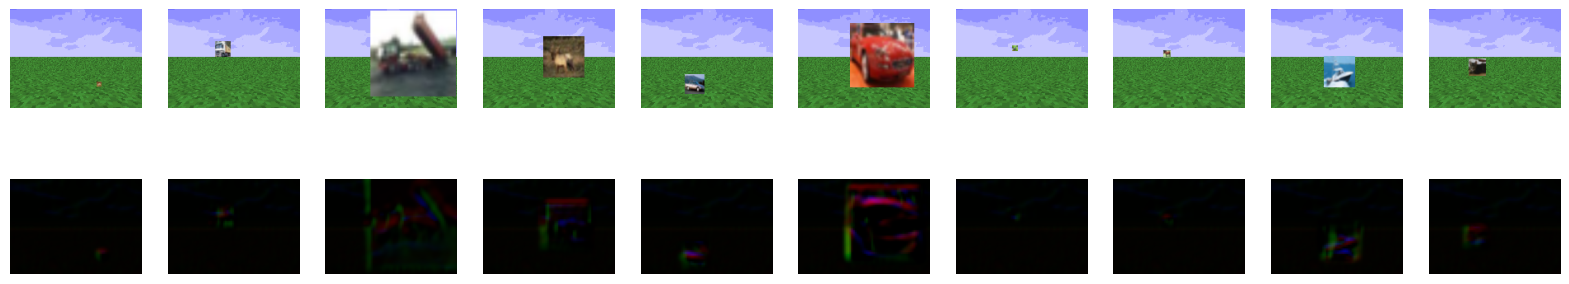

In [17]:
imgs = next(iter(train_loader))
processed = model[:5](imgs[0].to(device)).cpu().detach()
print(processed.shape)

fig, axes = plt.subplots(2, 10, figsize=(20,4))
for ax, im in zip(axes[0], imgs[0]):
    ax.imshow(im.movedim(0,2), cmap='gray')
    ax.axis('off')
for ax, im in zip(axes[1], rescaleZeroOne(processed)):
    ax.imshow(im.movedim(0,2)[...,:3], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

## Receptive Fields

In [21]:
layer = 5
img=8
plots_per_row=8
max_plots=32

100%|██████████| 32/32 [00:00<00:00, 390.79it/s]


<Figure size 500x500 with 0 Axes>

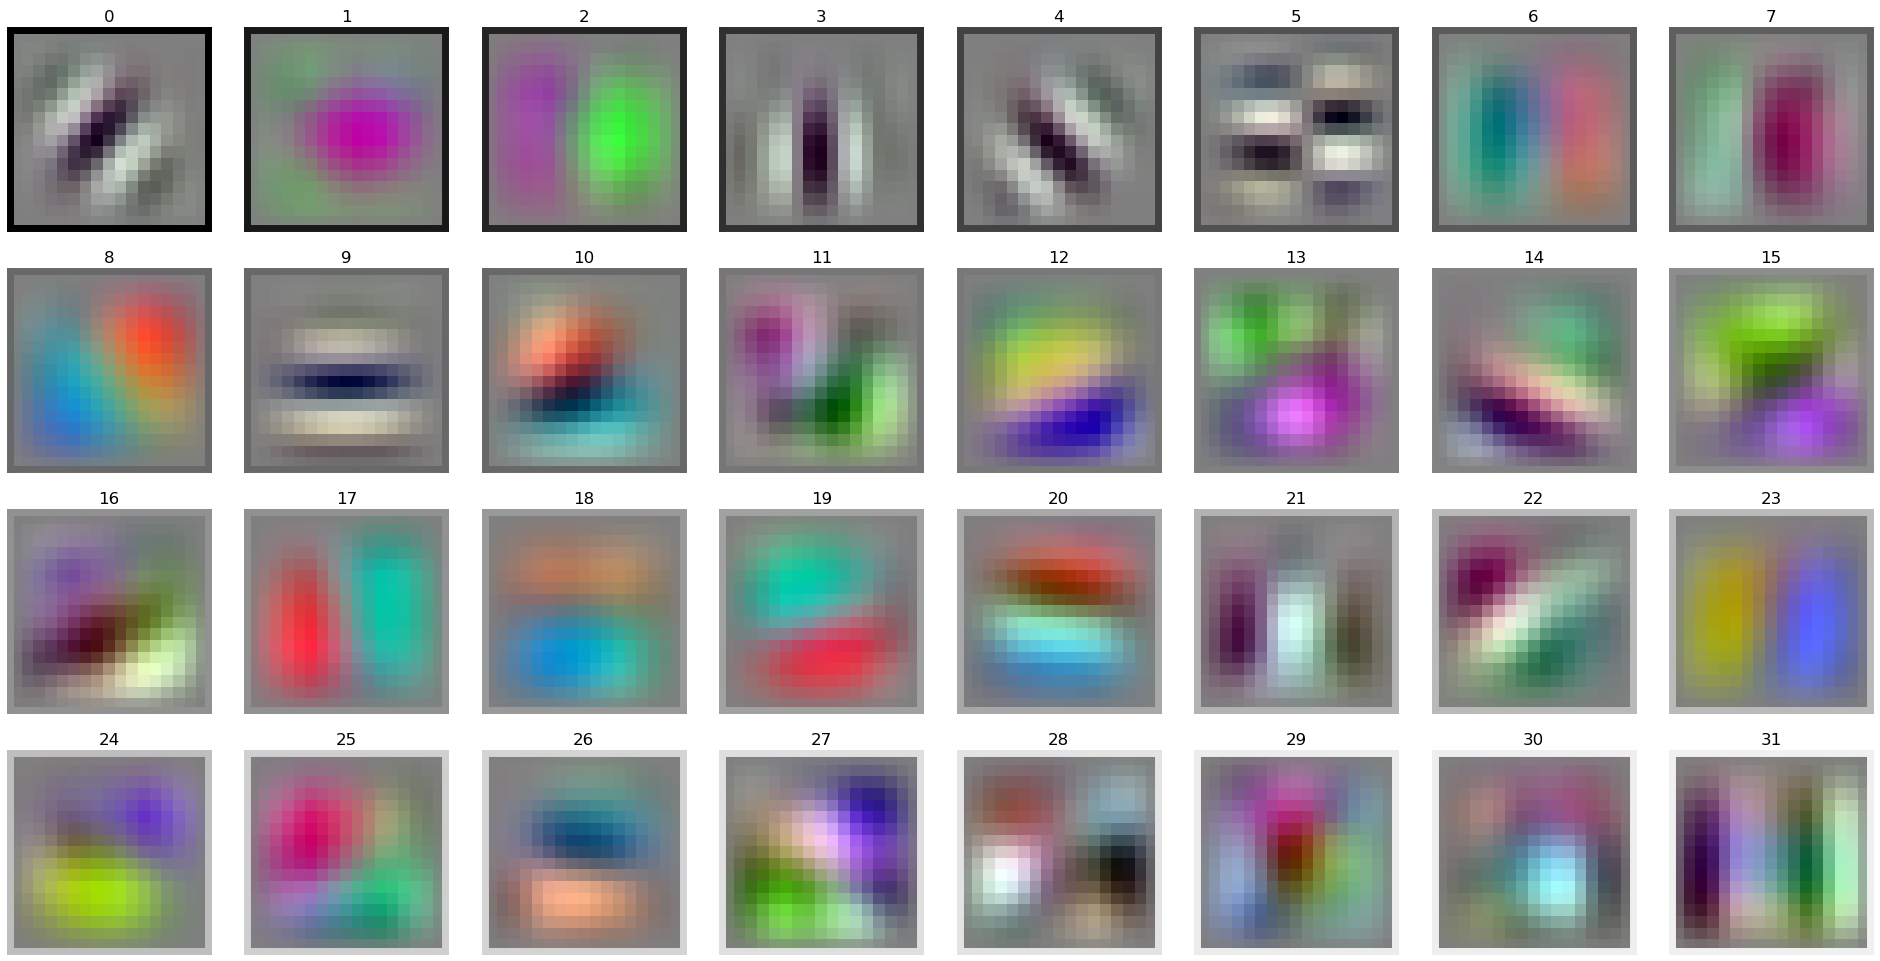

In [22]:
%matplotlib inline
eff_rfs = effective_receptive_field(model[:layer], n_batch=1, fill_value=0.0, device=device) # model[0].weight.detach().cpu()# TODO: High prio: fix bug in rf size estimation! padding? dilation, stride?
# order = torch.argsort(model[6].weight.sum(axis=(0,2,3)), descending=True).cpu()
sort = eff_rfs.abs().max(dim=3)[0].max(dim=2)[0].max(dim=1)[0]
# sort = eff_rfs.abs().sum(axis=(1,2,3))
order = torch.argsort(sort, descending=True)
eff_rfs = eff_rfs[order]
plt.figure(figsize=(5,5))
multiplot(eff_rfs, color=True, individ_rescale=True, plots_per_row=plots_per_row, max_plots=max_plots)
plt.show()

In [20]:
aaa

NameError: name 'aaa' is not defined

100%|██████████| 32/32 [00:00<00:00, 349.64it/s]


<Figure size 500x500 with 0 Axes>

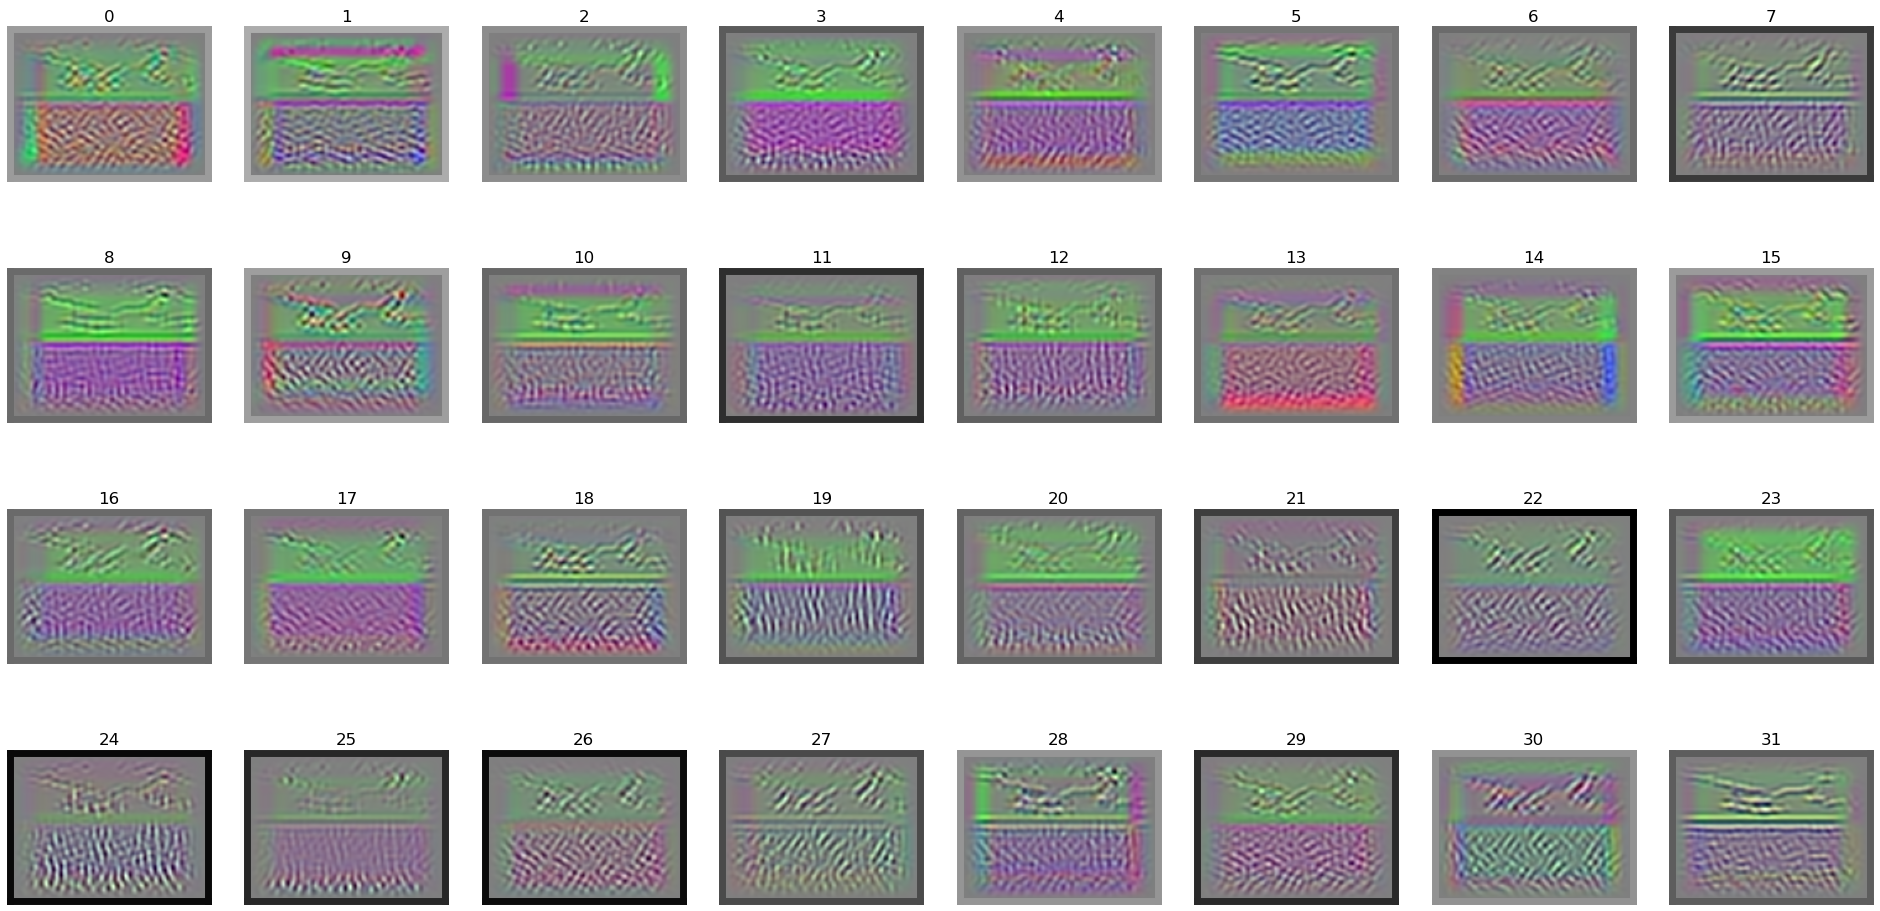

In [ ]:
eff_rfs = effective_receptive_field(model[:layer], n_batch=1, fill_value=imgs[0][img:img+1], device=device) # model[0].weight.detach().cpu()# TODO: High prio: fix bug in rf size estimation! padding? dilation, stride?
# order = torch.argsort(model[6].weight.sum(axis=(0,2,3)), descending=True).cpu()
# order = torch.argsort(eff_rfs.abs().sum(axis=(1,2,3)), descending=True)
eff_rfs = eff_rfs[order]
plt.figure(figsize=(5,5))
multiplot(eff_rfs, color=True, individ_rescale=True, plots_per_row=plots_per_row, max_plots=max_plots)

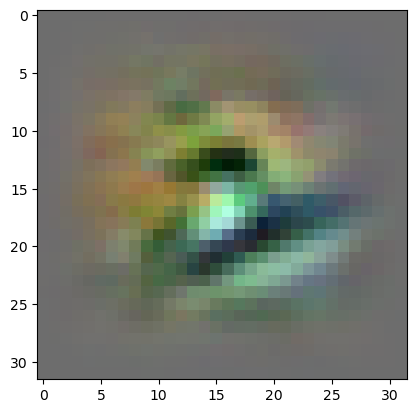

In [ ]:
plt.imshow(rescaleZeroOne(eff_rfs.sum(dim=0).movedim(0,2)))

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
def plot_hough(image, h, theta, d, rf_edges, hpeaks):
    # Generating figure 1
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    ax = axes.ravel()

    angle_step = 0.5 * np.diff(theta).mean()
    d_step = 0.5 * np.diff(d).mean()
    bounds = [np.rad2deg(theta[0] - angle_step),
            np.rad2deg(theta[-1] + angle_step),
            d[-1] + d_step, d[0] - d_step]
    ax[0].imshow(h, extent=bounds)
    ax[0].set_title('Hough transform')
    ax[0].set_xlabel('Angles (degrees)')
    ax[0].set_ylabel('Distance (pixels)')
    ax[0].axis('image')

    ax[1].imshow(image, cmap='gray')
    ax[1].set_ylim((image.shape[0], 0))
    ax[1].set_axis_off()
    ax[1].set_title('Detected lines')

    ax[2].imshow(rf_edges, cmap='gray')
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Edges')

    for _, angle, dist in zip(*hpeaks):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        slope = np.tan(angle + np.pi/2)
        ax[1].axline((x0, y0), slope=slope)
        ax[2].axline((x0, y0), slope=slope)

    plt.tight_layout()
    plt.show()

In [ ]:
from skimage.morphology import skeletonize
from skimage.filters import sobel

[0.36944444]


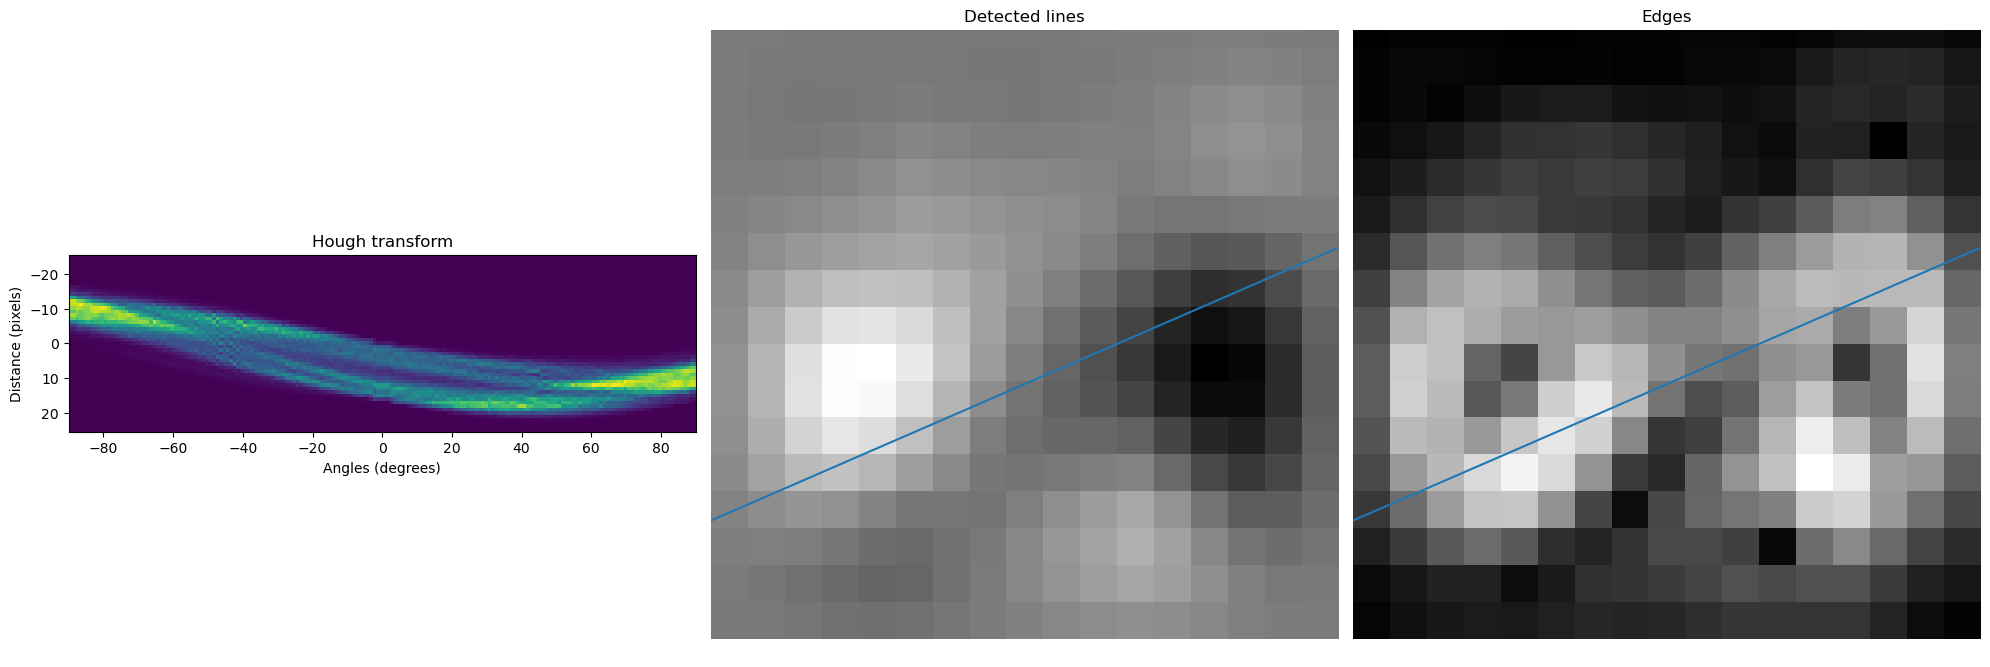

In [ ]:
image = eff_rfs[28][0]
rf_edges = np.zeros_like(image)
rf_edges[:] = image.numpy()#sobel(image.numpy())
rf_edges[np.abs(rf_edges)<np.mean(np.abs(rf_edges))]=0
# rf_edges = skeletonize(rf_edges > 0.5*rf_edges.max())
# rf_edges_pos = rf_edges

rf_edges = sobel(-image.numpy())
# rf_edges = skeletonize(rf_edges > 0.5*rf_edges.max())
# rf_edges = rf_edges + rf_edges_pos

# rf_edges_nms = torch.max_pool2d(torch.from_numpy(rf_edges)[None], kernel_size=3, stride=1, padding=1).numpy()
# rf_edges = rf_edges_nms[0]
n_thetas = 180
h, theta, d = weighted_hough_line(rf_edges, theta=n_thetas)
h=h**2
hpeaks = hough_line_peaks(h, theta, d, num_peaks=1) # TODO: Use probabilistic Hough line for connected lines?
print(hpeaks[1]/np.pi)

plot_hough(image, h, theta, d, rf_edges, hpeaks)

In [55]:
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

In [25]:
from scipy.fftpack import fftn as fourier, ifftn as ifourier
from skimage.transform import warp_polar
from receptive_fields.util.image import gabor_kernel, gaussian_kernel

(17, 17) [9 9]


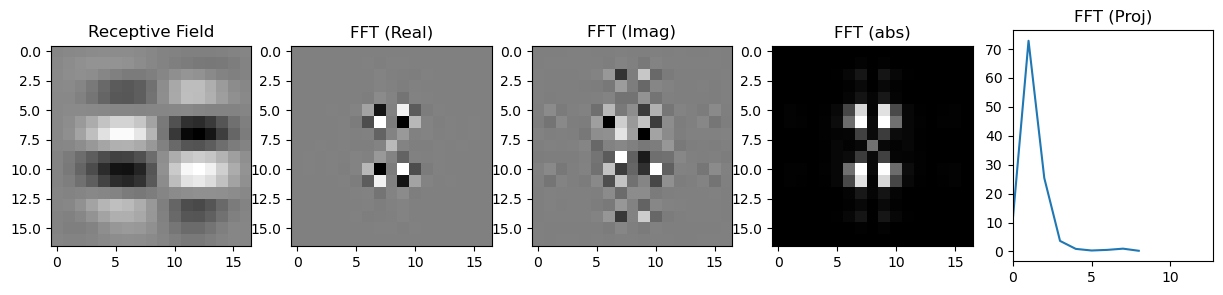

In [96]:
%matplotlib inline
sigma=5
image = rescaleZeroOne(eff_rfs[5][1].numpy())-0.5#rescaleZeroOne(eff_rfs[0][2].numpy())
frequencies = fourier(image)

shape = image.shape
m = np.array(shape)//2+1
print(shape, m)

# frequencies[np.abs(frequencies)<0.95*np.max(np.abs(frequencies))]=0

reordered = np.vstack([frequencies[m[0]:],frequencies[:m[0]]])
reordered = np.hstack([reordered[:,m[1]:],reordered[:,:m[1]]])
argm = np.unravel_index(np.argmax(np.abs(reordered)), shape=reordered.shape)
sign = np.sign(reordered[argm].real)
diff = argm-np.array(frequencies.shape)//2
dist = np.linalg.norm(diff,2)
freq = 1/(frequencies.shape[0]/dist)
theta_sign = np.sign(diff[1]*diff[0])
if theta_sign == 0:
    theta_sign=1
theta = theta_sign*np.arccos(np.abs(diff[1])/dist)


# detected= rescaleZeroOne(gabor_kernel(image.shape, frequency=freq, theta=theta, sigma_x=sigma, sigma_y=sigma, factor=sign))
detected = rescaleZeroOne(ifourier(frequencies).real)-0.5# * gaussian_kernel(shape, sigma_x=sigma, sigma_y=sigma))
fig, axes = plt.subplots(1, 5, figsize=(15,3))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Receptive Field")
reordered = np.vstack([frequencies[m[0]:],frequencies[:m[0]]])
reordered = np.hstack([reordered[:,m[1]:],reordered[:,:m[1]]])
axes[1].imshow(reordered.real, cmap='gray')
axes[1].set_title("FFT (Real)")
axes[2].imshow(reordered.imag, cmap='gray')
axes[2].set_title("FFT (Imag)")

frequencies_abs = np.abs(reordered)
axes[3].imshow(frequencies_abs, cmap='gray')
axes[3].set_title("FFT (abs)")
frqs = dict()
for i in range(shape[0]):
    for j in range(shape[1]):
        dist = np.round(j-(m[0]-1))#np.linalg.norm(, 2))
        val = frequencies_abs[i,j]
        if dist in frqs.keys():
            frqs[dist] += val
        else:
            frqs[dist] = val
sorted_frqs = dict(sorted(frqs.items()))
axes[4].plot(sorted_frqs.keys(),sorted_frqs.values())
axes[4].set_xlim(0,np.linalg.norm(m, 2))
axes[4].set_title("FFT (Proj)")

plt.show()

In [87]:
sorted_frqs

{0.0: 25.730999,
 1.0: 21.578915,
 2.0: 78.83224,
 3.0: 74.71666,
 4.0: 25.166866,
 5.0: 3.0660045,
 6.0: 8.279565,
 7.0: 1.9512699,
 8.0: 0.94973385,
 9.0: 0.42875665,
 10.0: 0.031103708,
 11.0: 0.006075558}

In [62]:
sorted(frqs)

[0.0,
 1.0,
 1.4142135623730951,
 2.0,
 2.23606797749979,
 2.8284271247461903,
 3.0,
 3.1622776601683795,
 3.605551275463989,
 4.0,
 4.123105625617661,
 4.242640687119285,
 4.47213595499958,
 5.0,
 5.0990195135927845,
 5.385164807134504,
 5.656854249492381,
 5.830951894845301,
 6.0,
 6.082762530298219,
 6.324555320336759,
 6.4031242374328485,
 6.708203932499369,
 7.0,
 7.0710678118654755,
 7.211102550927978,
 7.280109889280518,
 7.615773105863909,
 7.810249675906654,
 8.0,
 8.06225774829855,
 8.246211251235321,
 8.48528137423857,
 8.54400374531753,
 8.602325267042627,
 8.94427190999916,
 9.0,
 9.055385138137417,
 9.219544457292887,
 9.433981132056603,
 9.486832980505138,
 9.848857801796104,
 9.899494936611665,
 10.0,
 10.295630140987,
 10.63014581273465,
 10.816653826391969,
 11.313708498984761,
 11.40175425099138,
 12.041594578792296,
 12.727922061357855]

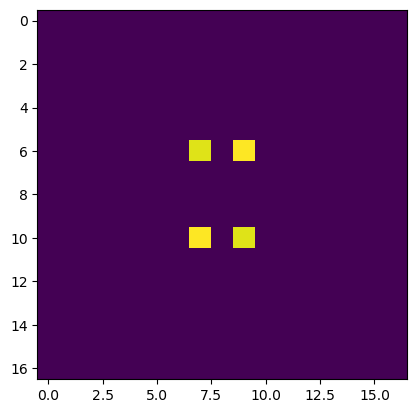

In [ ]:
plt.imshow(np.abs(reordered))

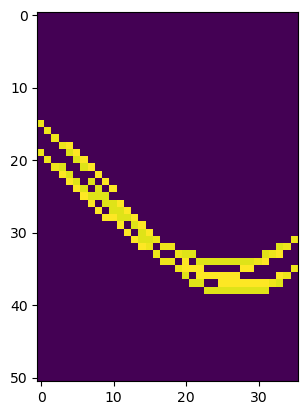

In [ ]:
h, theta, d = weighted_hough_line(np.abs(reordered), theta=36)
plt.imshow(h)

In [ ]:
argm = np.unravel_index(np.argmax(np.abs(frequencies)), shape=frequencies.shape)
dist = np.linalg.norm(argm-np.array(frequencies.shape)//2,2)
freq = 1/(frequencies.shape[0]/dist)
theta = np.arcsin(np.abs(diff[0])/dist)

interactive(children=(IntSlider(value=3, description='w', max=9, min=-3), Output()), _dom_classes=('widget-int…

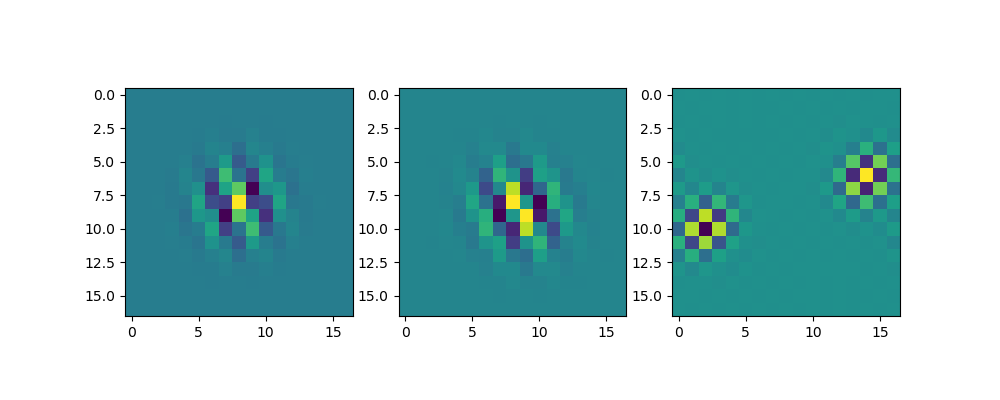

In [ ]:
%matplotlib widget
plt.close('all')
freq = 1e-12
sigma=2
theta =7*np.pi/8
image = gaussian_kernel(image.shape, sigma_x=4, sigma_y=4) + gaussian_kernel(image.shape, amplitude=-1, sigma_x=2, sigma_y=2)
# image = gabor_kernel(image.shape, frequency=freq, theta=theta, sigma_x=sigma, sigma_y=sigma, phase_offset=0, factor = 1, offset = 0)
frequencies = fourier(image)
# frequencies[np.abs(frequencies)<1.0*np.abs(frequencies).max()]=0
# frequencies[9:]=0
# frequencies = frequencies.real
fft_im = rescaleZeroOne(ifourier(frequencies).real)
combined =np.stack([image, fft_im, np.zeros_like(image)], axis=-1)
fig, axes = plt.subplots(1, 3, figsize=(10,4))
# im_0=axes[0].imshow(combined)
im_1=axes[0].imshow(rescaleZeroOne(fft_im))
reordered = np.vstack([frequencies[9:],frequencies[:9]])
reordered = np.hstack([reordered[:,9:],reordered[:,:9]])
im_2=axes[1].imshow(rescaleZeroOne(reordered.real))
im_3=axes[2].imshow(rescaleZeroOne(reordered.imag))

def update(w = 3):
    # image = gaussian_kernel((17,17), amplitude=1, sigma_x=w, sigma_y=w) + gaussian_kernel((17,17), amplitude=-2, sigma_x=1.5, sigma_y=1.5)
    image = gabor_kernel((17,17), frequency=1/w, theta=theta, sigma_x=sigma, sigma_y=sigma, phase_offset=0, factor = 1, offset = 0)
    frequencies = fourier(image)
    reordered = np.vstack([frequencies[9:],frequencies[:9]])
    reordered = np.hstack([reordered[:,9:],reordered[:,:9]])
    # im_0.set_data(combined)
    im_1.set_data(rescaleZeroOne(image))
    im_2.set_data(rescaleZeroOne(ifourier(frequencies.real).real))
    im_3.set_data(rescaleZeroOne(reordered.imag))
    # im_3.set_data(np.abs(reordered))
    fig.canvas.draw_idle()

interact(update);
plt.show()

interactive(children=(IntSlider(value=4, description='v', max=12, min=-4), IntSlider(value=8, description='w',…

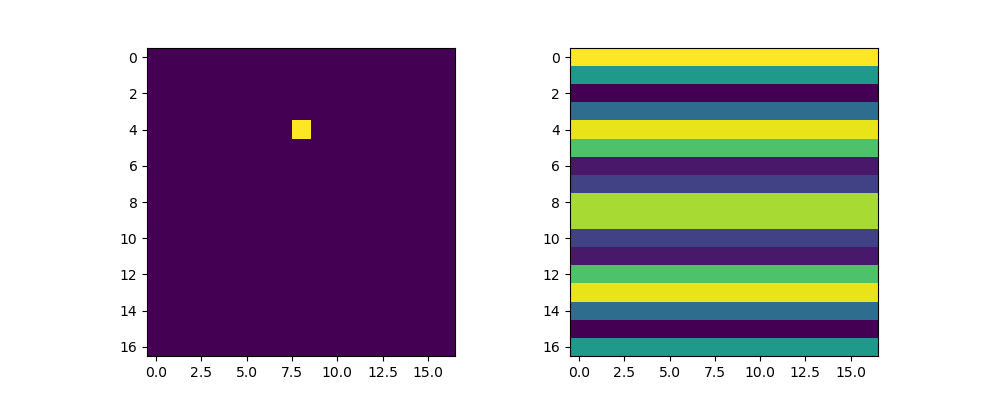

In [ ]:
%matplotlib widget
fig, axes = plt.subplots(1, 2, figsize=(10,4))

shape = image.shape
m = shape[0]//2

frequencies = np.zeros(shape)
frequencies[0,0]=1
reordered = np.vstack([frequencies[m:],frequencies[:m]])
reordered = np.hstack([reordered[:,m:],reordered[:,:m]])
img = ifourier(reordered)
# im_0=axes[0].imshow(combined)
im_1=axes[0].imshow(frequencies)
im_2=axes[1].imshow(rescaleZeroOne(img.real))

def update(v=4, w = m):
    frequencies = np.zeros(shape, dtype=np.complex128)
    frequencies[v,w]=1+1j
    # frequencies[-v-1,w]=1
    # frequencies[v,-w-1]=1
    frequencies[-v-1,-w-1]=1j
    reordered = np.vstack([frequencies[m:],frequencies[:m]])
    reordered = np.hstack([reordered[:,m:],reordered[:,:m]])
    img = ifourier(reordered)
    # im_0.set_data(combined)
    im_1.set_data(frequencies.real)
    im_2.set_data(rescaleZeroOne(img.real))
    fig.canvas.draw_idle()

interact(update);
plt.show()

The following cell should be run only with a GPU backend!

Other than that, it seems that the activation triggered average results in 'nicer' RFs for the first layer, in higher layers the effective receptive fields are usually smoother (and a lot faster!)

In [ ]:
cmap = plt.get_cmap('viridis_r')

64it [00:32,  1.96it/s]


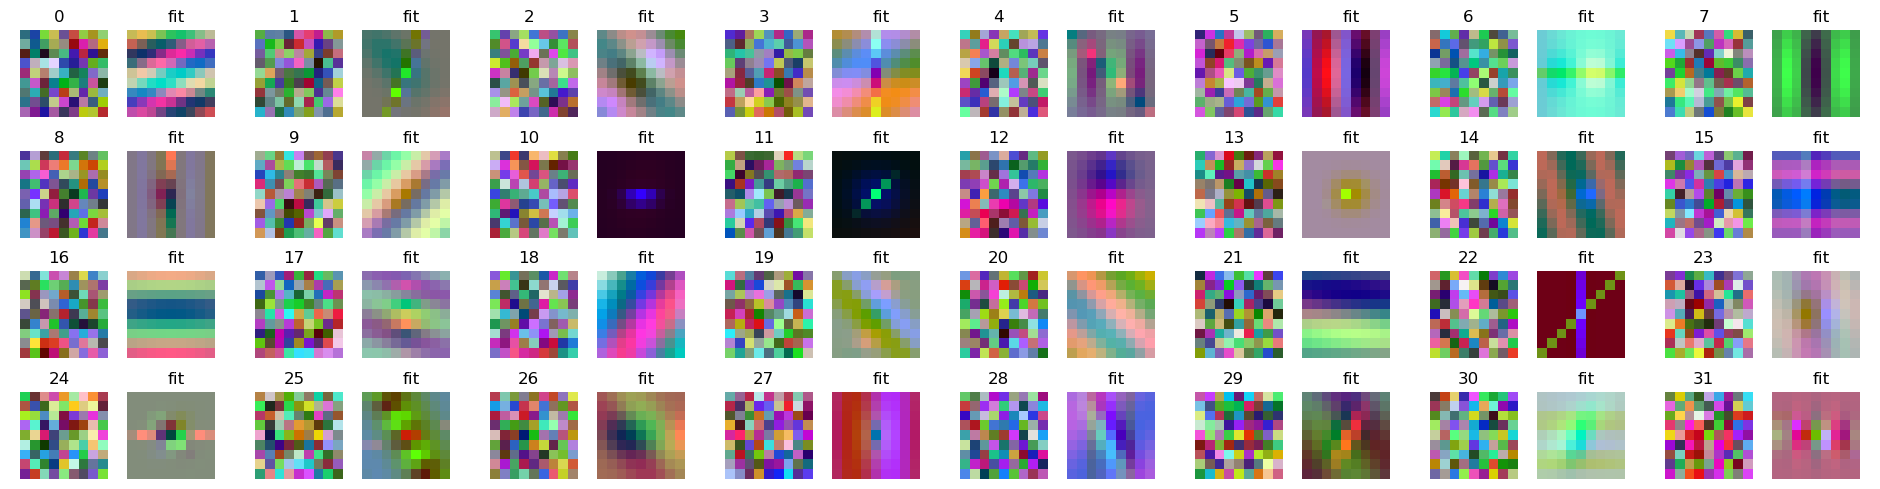

In [ ]:
%matplotlib inline
num_rows = max(1,len(eff_rfs)//8)
fig, axes = plt.subplots(num_rows, 8*2, figsize=(24,num_rows*1.5))
all_fitted=[]
for i, ax in tqdm(enumerate(axes.flat)):
    eff_rf= eff_rfs[i//2].movedim(0,2).numpy()
    if i%2==1:
        fitted = np.zeros_like(eff_rf)
        fitted[...,0] = fit_gabor_filter(eff_rf[...,0], wavelength=8, maxiter=5000)[0]
        fitted[...,1] = fit_gabor_filter(eff_rf[...,1], wavelength=8, maxiter=5000)[0]
        fitted[...,2] = fit_gabor_filter(eff_rf[...,2], wavelength=8, maxiter=5000)[0]
        all_fitted.append(fitted)
        ax.imshow(rescaleZeroOne(fitted))
        ax.set_title("fit")
        ax.axvline(eff_rf.shape[1]+0.1, 0, shape[1], color=(0,0,0,0))
    else:
        ax.imshow(rescaleZeroOne(eff_rf))
        ax.set_title(str(i//2))
        ax.axvline(-1.1, 0, eff_rf.shape[1], color=(0,0,0,0))
    ax.axis('off')

In [ ]:
aaa

NameError: name 'aaa' is not defined

In [ ]:
eff_rfs = dataset_average(model[:5], train_loader, device=device) # TODO: Also buggy? :D

if len(eff_rfs)==1:
    plt.imshow(torch.mean(eff_rfs[0], dim=0), cmap="gray")
    plt.axis('off')
else:
    fig, axes = plt.subplots(4, 8, figsize=(24,12))
    for eff_rf, ax in zip(eff_rfs, axes.flat):
        ax.imshow(torch.mean(eff_rf, dim=0), cmap="gray")
        ax.axis('off')

  0%|          | 0/32 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
back_maxs = backprop_maximization(model[:1], n_iter=128, batch_size=1, reduction=True, smoothened=True, device=device)

fig, axes = plt.subplots(2, 5, figsize=(20,8))
for class_name, back_max, ax in zip(train_data.classes, back_maxs, axes.flat):
    out = model(back_max.repeat(1,1,1,1).to(device))
    index = out.argmax()
    prob = out.max()

    ax.imshow(back_max.movedim(0,2).cpu())
    ax.axis('off')
    ax.set_title(class_name + " - {0:.0%}".format(prob))

  0%|          | 0/32 [00:00<?, ?it/s]


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [1, 32]

In [ ]:
eff_rfs = effective_receptive_field(model, n_batch=2048, device=device)
fig, axes = plt.subplots(2, 5, figsize=(20,8))

for class_name, eff_rf, ax  in zip(train_data.classes, eff_rfs, axes.flat):
    ax.imshow(rescaleZeroOne(eff_rf.movedim(0,2)))
    ax.axis('off')
    ax.set_title(class_name)

  0%|          | 0/128 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2048x288 and 320x128)